### Sensitivity to centroid miss of RRG and CNN estimators

In [ ]:
import numpy as np
import math as ma
import matplotlib.pyplot as plt

from os.path import expanduser

from wlenet import config
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import get_output_dim, load_model, load_spec, save_spec, print_spec
from wlenet.simulation.galsim_simulation import GalsimSimulation
from wlenet.dataset.io import load_sim
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.models.predict import predict_test_time_aug
from wlenet.dataset.normalization import norm_mean_std

In [2]:
model_spec = load_spec('cnn_image_clash_uniform_mse_lsq')
cosmos_sim_name = 'clash_003_test'
shift_range_proportion_bins = np.array([0.0, 0.25, 0.5, 0.75])
noise_kernel_name = 'clash'
noise_kernel_factor = 1.0
num_gals = 200000
num_batches = 2000
save_figures = True

In [3]:
print_spec(model_spec)

{'arch_name': 'cnn_image',
 'calib': (-0.0015137530696129763, 0.007540313076099592, 0.0004530938759174512, 0.010357044292399475),
 'kwargs_arch': {'dropout_dense_rate': 0.3, 'out_dim': 2, 'use_discriminator': False, 'use_dropout_dense': True},
 'kwargs_dataset': {'noise_kernel_factor': 1.0,
                    'noise_kernel_name': 'clash',
                    'post_sim': {'flux_cut_min': -inf, 'flux_factor': 0.32, 'intensity_cutoff': 0.012},
                    'sim_names_test': ['clash_003_test'],
                    'sim_names_train': ['clash_004_train'],
                    'target_header_path': None},
 'kwargs_train': {'epochs': 100, 'label_loss': 'mean_squared_error', 'patience': 10},
 'trained_name': 'cnn_image_clash_uniform_mse_lsq'}


In [4]:
model = load_model(model_spec, load_weights=True, show_summary=False)

In [5]:
noise_kernel_path = config['calibration_path'] + '/' + noise_kernel_name + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) * noise_kernel_factor

In [6]:
from wlenet.reduction.stamps import half_light_radii, chi_shapes, rrg_shapes


def model_performance(x_seq_test, y_seq_test):
    
    y_seq_ptta = predict_test_time_aug(norm_mean_std(x_seq_test), model)
    y_seq_ptta, calib_ptta, rmse_ptta = step_bias_calib(y_seq_test, y_seq_ptta, verbose=True)
    
    return rmse_ptta


def rrg_performance(x_seq_test, y_seq_test, max_radius=10, num_trials=60):
    
    psf_radius = (0.12 / 0.065) / 2.355    
    radii = half_light_radii(x_seq_test)
    y_rrg = rrg_shapes(x_seq_test, radii, psf_radius)
    inds = np.all(np.abs(y_rrg) < 1.0, axis=1)
    _, _, rmse = step_bias_calib(y_seq_test[inds, :], y_rrg[inds, :], verbose=True)

    return rmse

In [7]:
cosmos_sim_path = config['simulation_configs_path'] + '/' + cosmos_sim_name + '_sim.json'
gss = GalsimSimulation(cosmos_sim_path)
gss.args.test_train = 'test'
gss.args.num_gals = num_gals

In [8]:
gss.init()

Loading the RealGalaxyCatalog real_galaxy_catalog_25.2.fits (preload=1)
Using valid-index file ~/datasets/wlenet/calibration/cosmos_valid_indices.npy
Using weight-index file ~/datasets/wlenet/calibration/cosmos_to_clash_weights.npy
Splitting catalog samples to train and test samples using the static seed
Using the static seed for train/test split
Total catalog galaxies: 87798
Valid catalog galaxies: 87750
Train catalog galaxies: 65756
Test catalog galaxies : 21994
Using the dynamic seed for the rest of this simulation


In [ ]:
test_model_rmse = np.zeros((len(shift_range_proportion_bins), 2))
test_rrg_rmse = np.zeros((len(shift_range_proportion_bins), 2))

for i in range(len(shift_range_proportion_bins)):

    gss.args.shift_range_proportion = shift_range_proportion_bins[i]

    cosmos_stamps, cosmos_shears, cosmos_metadata = gss.render_stamps()
    cosmos_stamps = cosmos_stamps[:, :, :, np.newaxis]
    cosmos_stamps_ = cosmos_stamps.copy()
    cosmos_stamps_[cosmos_stamps_ < model_spec['kwargs_dataset']['post_sim']['intensity_cutoff']] = 0
    cosmos_stamps_ = cosmos_stamps_ * model_spec['kwargs_dataset']['post_sim']['flux_factor']

    seq = CorrelatedNoiseSequence({'x': cosmos_stamps_, 'y': cosmos_shears}, noise_kernel, norm_func=None)
    x_seq_test, y_seq_test, inds_seq_test = generate_batches(seq, num_batches, batch_idx_start=0)

    test_model_rmse[i, :] = model_performance(x_seq_test, y_seq_test)
    test_rrg_rmse[i, :] = rrg_performance(x_seq_test, y_seq_test)    

    print(test_model_rmse[i, :])
    print(test_rrg_rmse[i, :])

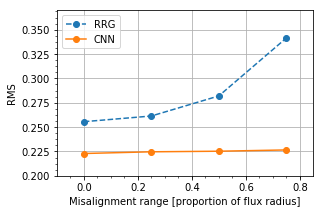

In [10]:
plt.rcParams['figure.figsize'] = (4.75,3.15)
fig, ax1 = plt.subplots()

ax1.set_xlabel("Misalignment range [proportion of flux radius]")
ax1.set_ylabel('RMS')
ax1.plot(shift_range_proportion_bins, np.mean(test_rrg_rmse, 1), 'o--', label='RRG')
ax1.plot(shift_range_proportion_bins, np.mean(test_model_rmse, 1), 'o-', label='CNN')
plt.ylim([0.20, 0.37])
plt.xlim([-0.1, 0.85])
plt.grid('on')

ax1.minorticks_on()
ax1.legend()
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/performance/sensitivity_to_translation.pdf')
    plt.savefig(fig_path)